In [514]:
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
import yfinance as yf
import pandas as pd
import numpy as np
import os
from scipy.stats import norm

plt.style.use('Solarize_Light2')

### Constants

In [515]:
WINDOW = 21

n_ema = f"{WINDOW}-EMA"

### Loading data

In [516]:
if os.path.exists("data.csv"):
    df = pd.read_csv("data.csv", index_col=0)
else:
    gold_ticker = yf.Ticker("GC=F")
    df = gold_ticker.history(period="max", interval='1h')
    df.to_csv("data.csv")

df.index = pd.to_datetime(df.index, utc=True)

df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)
df.columns = df.columns.str.lower()

# display(df.shape)
# display(df.head(3))

### Creating needed metrics

In [517]:
df[n_ema] = df['low'].ewm(span=WINDOW, adjust=False).mean()
df["200-EMA"] = df['low'].ewm(span=200, adjust=False).mean()
df['bb_low'] = df[n_ema] - 3 * df['low'].rolling(window=WINDOW).std()

df.dropna(inplace=True)

df.head()

,open,high,low,close,21-EMA,200-EMA,bb_low
Datetime,,,,,,,
2022-10-03 18:00:00+00:00,1703.900024,1709.400024,1703.400024,1708.400024,1679.636097,1669.889872,1645.482472
2022-10-03 19:00:00+00:00,1708.400024,1710.400024,1704.199951,1709.400024,1681.869175,1670.231266,1643.616601
2022-10-03 20:00:00+00:00,1709.300049,1710.000000,1707.400024,1708.599976,1684.190161,1670.601105,1641.633628
2022-10-03 22:00:00+00:00,1708.400024,1710.900024,1707.000000,1709.300049,1686.263783,1670.963283,1640.477778
2022-10-03 23:00:00+00:00,1709.199951,1711.599976,1708.800049,1710.000000,1688.312534,1671.339768,1639.594824


### Strategy

In [518]:
SIGNALS = {
    'BUY': 1,
    'SELL': -1
}

# sell_filter = (df['200-EMA'] > df[n_ema])
buy_filter = (df['200-EMA'] < df[n_ema]) & (df['low'] < df['200-EMA'])

df['Signal'] = 0  # Default to hold/no position
df.loc[buy_filter, 'Signal'] = SIGNALS['BUY']
# df.loc[sell_filter, 'Signal'] = SIGNALS['SELL']

In [519]:
df.reset_index(inplace=True)

df['PnL'] = 0.0

is_trade_on = False

entry = 0.0
sl = 0.0
tp = 0.0

def trade_off():
    global is_trade_on
    global entry
    global sl

    is_trade_on = False
    entry = 0.0
    sl = 0.0

# Loop through candles and execute trades
for i, row in df.iterrows(): # row for reading, i for writing
    if is_trade_on:
        is_long = tp - sl > 0
        if is_long:
            if row['low'] <= sl:
                df.loc[i, 'PnL'] = -1
                trade_off()
            if row['high'] > tp:
                df.loc[i, 'PnL'] = 1
                trade_off()
        else:
            if row['high'] >= sl:
                df.loc[i, 'PnL'] = -1
                trade_off()
            if row['low'] < tp:
                df.loc[i, 'PnL'] = 1
                trade_off()
    else:
        if row['Signal'] == SIGNALS['BUY']:
            is_trade_on = True
            entry = row['close']
            sl = row['bb_low']
            tp = entry + (entry - sl)
            # if row['low'] <= sl: # instant check
            #     df.loc[i, 'PnL'] = -1
            #     trade_off()

        # if row['Signal'] == SIGNALS['SELL']:
        #     is_trade_on = True
        #     entry = row[n_ema] + PRICE_DEVIATION['HIGH']
        #     sl = entry + TRADE_OPTIONS['SL']
        #     tp = entry - TRADE_OPTIONS['TP']
        #     if row['high'] >= sl: # instant check
        #         df.loc[i, 'PnL'] = -1
        #         trade_off()

In [520]:
df.loc[df['PnL'] != 0, 'PnL'].value_counts(normalize=True).to_frame()

,proportion
PnL,
1.0,0.531915
-1.0,0.468085


In [521]:
df[df['PnL'] != 0]['PnL'].count()

94

In [522]:
df['Cumulative_PnL'] = df['PnL'].cumsum()

df['Cumulative_PnL'].iloc[-1]

6.0

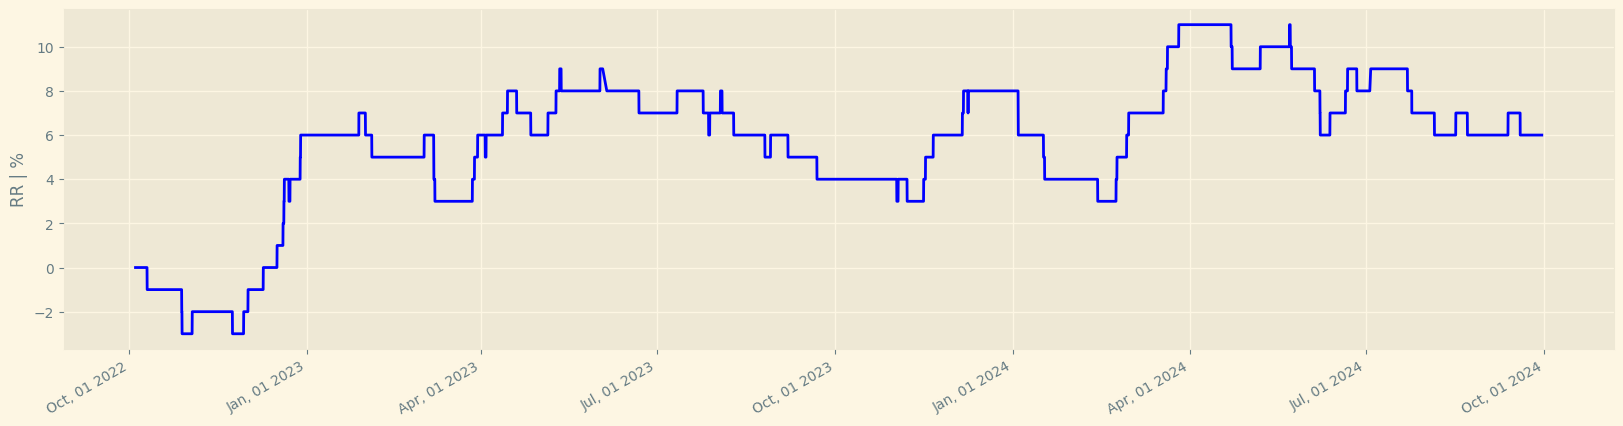

In [523]:
df.set_index('Datetime', inplace=True)

# Plot the Strategy returns
df['Cumulative_PnL'].plot(
        label='Strategy', 
        figsize=(20, 5), 
        color='blue', 
        xlabel='',
        ylabel='RR | %'
    )

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter("%b, %d %Y")
plt.gca().xaxis.set_major_formatter(date_format)